    # Output CN plot

In [69]:
import matplotlib
import matplotlib.pyplot as plt
# imports
import scgenome.plotting as pl
import h5py
import anndata
import numpy as np

In [70]:
import os
print(os.getcwd())


/Users/haraldme/git/Lagergren Lab/CopyTree/VICTree/victree/src/experiments


In [71]:
import json
base_path = "../../output/tetralith_runs"
data_base_path = '../../data/bahlis_10x/patient_MM-29.h5ad'
patient_name = "patient_MM-29"
hyper_params = "K14L5i150step0p1splitELBOLambda100kInverseqTTemp500"
experiment_seed = ""
path = os.path.join(base_path, patient_name)
path = os.path.join(path, hyper_params)
path = os.path.join(path, experiment_seed)

out_file = anndata.read_h5ad(os.path.join(path, 'victree.out.h5ad')) # 014
model_file = h5py.File(os.path.join(path, 'victree.model.h5')) # 014
with open(os.path.join(path, "victree.config.json")) as file:
    config_file = json.load(file)

print(f'out file keys: {out_file}')
print(f'model file keys: {model_file.keys()}')
print(f'config keys: {config_file}')

adata = anndata.read_h5ad(data_base_path)

out file keys: AnnData object with n_obs × n_vars = 1616 × 5285
    obs: 'victree-mu', 'victree-mt-lambda', 'victree-mt-alpha', 'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'
    var: 'target_bin', 'chr', 'start', 'end'
    uns: 'victree-elbo', 'victree-eps-alpha', 'victree-eps-beta', 'victree-tree-graph', 'victree-tree-newick', 'victree-tree-probs'
    obsm: 'victree-clone-probs'
    varm: 'victree-cn-pprobs', 'victree-cn-sprobs'
    layers: 'victree-cn-marginal', 'victree-cn-viterbi'
model file keys: <KeysViewHDF5 ['VarTreeJointDist', 'qCMultiChrom', 'qEpsilonMulti', 'qMuTau', 'qPi', 'qT', 'qZ']>
config keys: {'qZ_temp': 1.0, 'qT_temp': 500.0, 'merge_and_split_interval': 5, 'step_size_delay': 2.0, 'step_size_forgetting_rate': 0.7, 'step_size_scheme': 'None', 'batch_size': 20, 'SVI': False, 'split': 'ELBO', 'curr_it': 145, 'qc_smoothing': False, '_diagnostics': False, 'step_size': 0.1, 'annealing': 1.0, '_n_nodes': 14, '_n_states': 7, '_eps0': 0.01, '_n_cells': 16

/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [72]:
print(out_file.layers.keys())
print(out_file.obs.keys())

KeysView(Layers with keys: victree-cn-marginal, victree-cn-viterbi)
Index(['victree-mu', 'victree-mt-lambda', 'victree-mt-alpha',
       'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'],
      dtype='object')


In [73]:
# get cell assignment and cell copy number
top_z = out_file.obsm['victree-clone-probs'][...].argmax(axis=1)
clone_cn_np = out_file.layers['victree-cn-marginal'][...].argmax(axis=-1)
cell_cn = clone_cn_np[top_z, :]

In [74]:
chr_codes = {c: c[3:] for c in adata.var['chr'].unique()}
adata.var['chr'] = adata.var['chr'].map(chr_codes)

ELBO: 


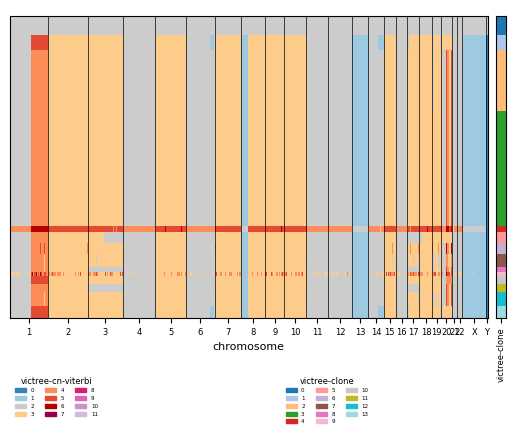

In [75]:
%matplotlib inline
#out_file.layers['victree-cn-marginal'] = cell_qc.get_viterbi()[1:].numpy()
elbo = out_file
print(f"ELBO: ")
g = pl.plot_cell_cn_matrix_fig(out_file, 'victree-cn-viterbi', cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'], max_cn=7)

In [76]:
E_q_mu = out_file.obs['victree-mu']
print(f"E_q[mu] max: {E_q_mu.max()} min: {E_q_mu.min()}")

E_q[mu] max: 1.3320515155792236 min: 0.8719363212585449


In [77]:
adata.obs['victree-clone'] = out_file.obs['victree-clone']
adata.obs['clone'] = top_z

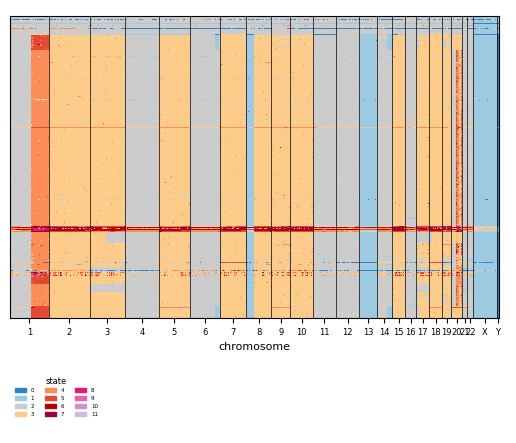

In [78]:
g = pl.plot_cell_cn_matrix_fig(adata, 'state', cell_order_fields=['clone'])

<Axes: xlabel='chromosome'>

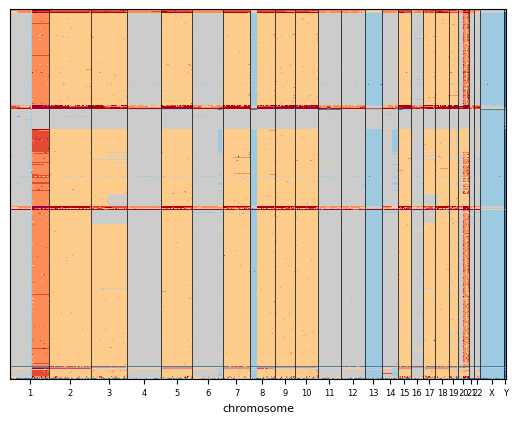

In [79]:
pl.plot_cell_cn_matrix(adata, 'state', cell_order_fields=['cluster_id'], max_cn=7)['ax']

/var/folders/gt/k64xtzx97m9dchpngd2j_xp40000gp/T/ipykernel_19696/4006104823.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(mst, prog="dot")


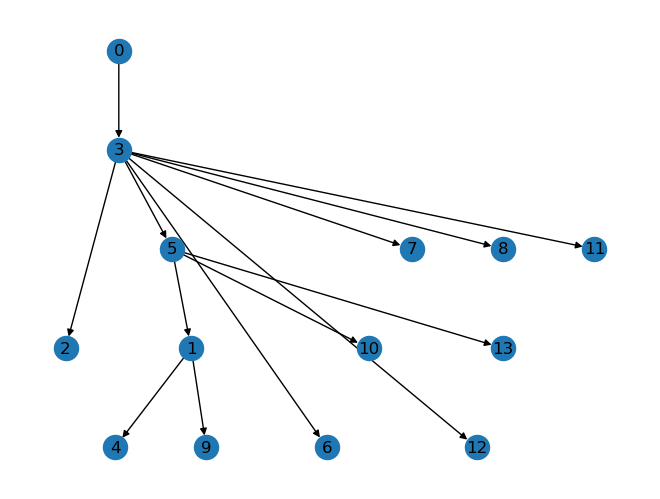

In [80]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
adj_matrix = out_file.uns['victree-tree-graph']
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
mst = nx.maximum_spanning_arborescence(G)
pos = graphviz_layout(mst, prog="dot")
nx.draw(mst, pos=pos, with_labels=True)

In [81]:
qZ_probs = out_file.obsm['victree-clone-probs'][...]
clonal_fractions = np.mean(qZ_probs, axis=0)
print(clonal_fractions)

[0.0625     0.05113464 0.200415   0.38329107 0.02092374 0.035912
 0.03694159 0.04147327 0.01922666 0.01250514 0.02535367 0.02594673
 0.04639181 0.03798459]


In [82]:
import numpy as np
np.unique(top_z, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([101,  80, 326, 616,  33,  58,  59,  68,  31,  21,  41,  42,  76,
         64]))

In [87]:
trees = out_file.uns['victree-tree-newick']
trees_weights = out_file.uns['victree-tree-probs']

In [96]:
qt = model_file


TypeError: initial_value must be str or None, not numpy.bytes_

In [ ]:
pos = graphviz_layout(trees[0], prog="dot")
nx.draw(trees[0], pos=pos, with_labels=True)

In [88]:

for t in zip(trees, trees_weights):
    print(t[0])
    print(t[1])
    print('---')

b'((2,((4,9)1,10,13)5,6,7,8,11,12)3)0'
nan
---
